In [1]:
from flo import DGraph, to_kelvin, DParams
from named_types import FloParamsHouse0
import dotenv
import pendulum
from sqlalchemy import create_engine, desc, asc, or_
from sqlalchemy.orm import sessionmaker
from fake_config import Settings
from fake_models import MessageSql
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import pandas as pd
from datetime import timedelta
import json

PRINT = False
house_alias = 'beech'
timezone = 'America/New_York'
YEAR, MONTH, DAY, HOUR = 2025, 2, 13, 4
start_ms = pendulum.datetime(YEAR, MONTH, DAY, HOUR, tz=timezone).timestamp() * 1000

# settings = Settings(_env_file=dotenv.find_dotenv())
# engine = create_engine(settings.db_url.get_secret_value())
# Session = sessionmaker(bind=engine)
# session = Session()

# flo_params_msg: List[MessageSql] = session.query(MessageSql).filter(
#     MessageSql.message_type_name == "flo.params.house0",
#     MessageSql.from_alias.like(f'%{house_alias}%'),
#     MessageSql.message_persisted_ms >= start_ms - 10*60*1000,
#     MessageSql.message_persisted_ms <= start_ms + 5*60*1000,
# ).order_by(desc(MessageSql.message_persisted_ms)).first()

# # Save as json
# messages_dict = flo_params_msg.to_dict()
# with open('messages.json', 'w') as file:
#     json.dump(messages_dict, file, indent=4)
# print("Saved messages to json")

def from_dict_msg(data):
    message = MessageSql(
            message_id=data["MessageId"],
            from_alias=data["FromAlias"],
            message_type_name=data["MessageTypeName"],
            message_persisted_ms=data["MessagePersistedMs"],
            payload=data["Payload"],
            message_created_ms=data.get("MessageCreatedMs")  # This is optional
        )
    return message

# Load the message from the JSON file
with open('messages.json', 'r') as file:
    messages_dict = json.load(file)
message_loaded = from_dict_msg(messages_dict)

flo_params = FloParamsHouse0(**message_loaded.payload)


In [2]:
g = DGraph(flo_params)
g.solve_dijkstra()
# g.plot()

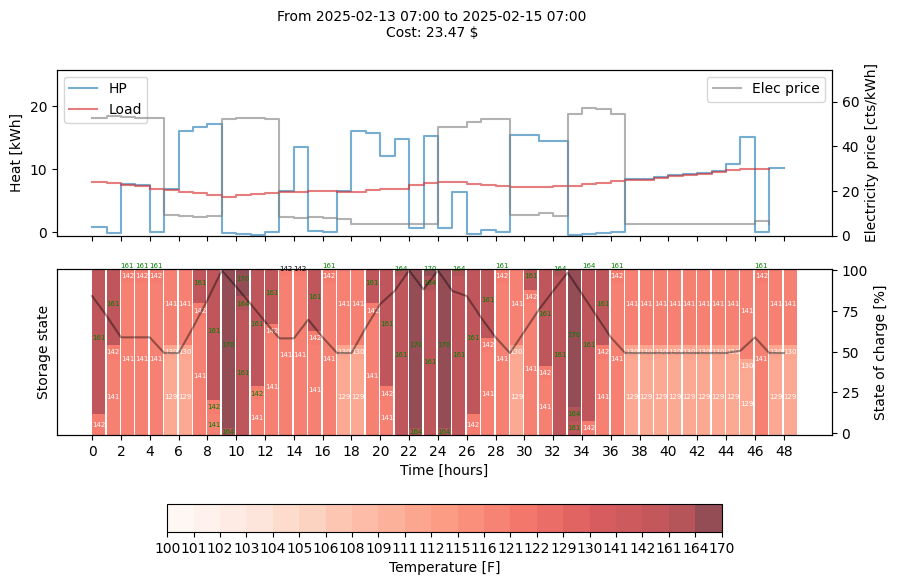

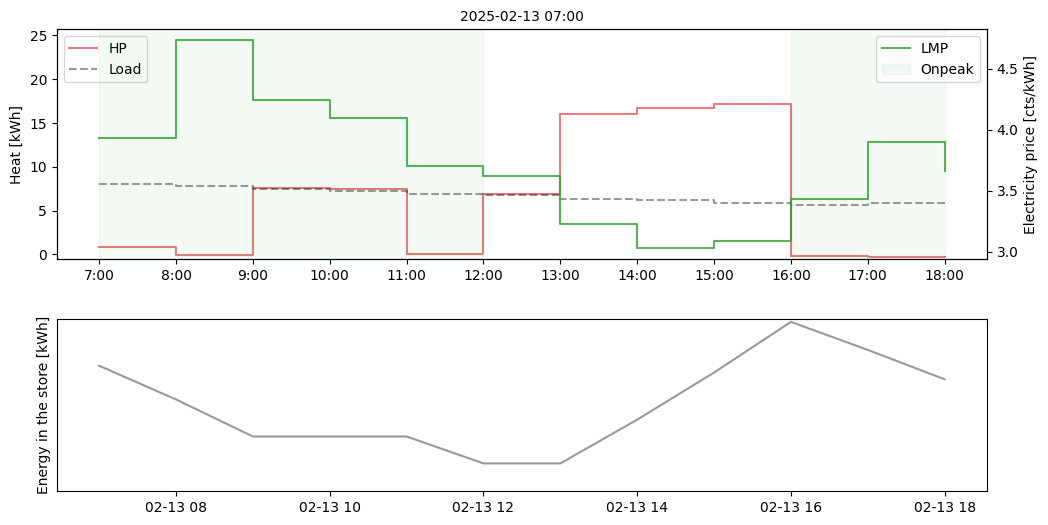

In [3]:
flo_params2 = flo_params.model_copy()
flo_params2.DdDeltaTF = 45
g2 = DGraph(flo_params2)
g2.solve_dijkstra()
g.plot()
g.quick_plot()
# g2.plot()

temps = list(range(40,180))
delta_t = [g2.params.delta_T(x) for x in temps]

# plt.plot(temps, delta_t)
# plt.scatter(g2.params.dd_rswt, g2.params.dd_delta_t)
# plt.scatter(g2.params.intermediate_rswt, g2.params.delta_T(g2.params.intermediate_rswt))
# plt.scatter(g2.params.no_power_rswt, 0)
# plt.show()

In [4]:
from flo import DNode

def find_3_hour_state(branch1, branch2, branch3, node):
    node1 = charge_from(node) if branch1 else discharge_from(node)
    node2 = charge_from(node1) if branch2 else discharge_from(node1)
    node3 = charge_from(node2) if branch3 else discharge_from(node2)

    cost = 0

    if not branch1: #discharing in first hour
        RSWT = g.params.rswt_forecast[node['time_slice']]
        if node['top_temp'] < RSWT or node1['top_temp'] < RSWT-g.params.delta_T(RSWT):
            return None, None
    else:
        cost1 = round(g.params.elec_price_forecast[node['time_slice']] * g.params.max_hp_elec_in /100,2)
        print(f"Charging during hour 1 costed {cost1}")
        cost += cost1
    if not branch2: #discharing in second hour
        RSWT = g.params.rswt_forecast[node['time_slice']+1]
        if node1['top_temp'] < RSWT or node2['top_temp'] < RSWT-g.params.delta_T(RSWT):
            return None, None
    else:
        cost2 = round(g.params.elec_price_forecast[node['time_slice']+1] * g.params.max_hp_elec_in /100,2)
        print(f"Charging during hour 2 costed {cost2}")
        cost += cost2
    if not branch3: #discharing in third hour
        RSWT = g.params.rswt_forecast[node['time_slice']+2]
        if node2['top_temp'] < RSWT or node3['top_temp'] < RSWT-g.params.delta_T(RSWT):
            return None, None
    else:
        cost3 = round(g.params.elec_price_forecast[node['time_slice']] * g.params.max_hp_elec_in /100,2)
        print(f"Charging during hour 3 costed {cost3}")
        cost += cost3
    return node3, cost

def discharge_from(node):
    thermocline1 = node['thermocline1']
    thermocline2 = node['thermocline2']
    top_temp = node['top_temp']
    middle_temp = node['middle_temp']
    bottom_temp = node['bottom_temp']
    time_slice = node['time_slice']
    params: DParams = g2.params #node['params']

    if top_temp - params.delta_T(top_temp) < bottom_temp or middle_temp is not None:
        # create the stack of temperatures
        # find the node that matches energy
        flo_params_temporary = flo_params2.model_copy()
        flo_params_temporary.HorizonHours = 2
        flo_params_temporary.InitialTopTempF = top_temp if top_temp<=175 else 175
        flo_params_temporary.InitialBottomTempF = bottom_temp if middle_temp is None else middle_temp
        flo_params_temporary.InitialThermocline = thermocline1 if thermocline2 is None else (params.num_layers-thermocline2+thermocline1)
        # print(f"{flo_params_temporary.InitialTopTempF}({flo_params_temporary.InitialThermocline}){flo_params_temporary.InitialBottomTempF}")
        temporary_g = DGraph(flo_params_temporary)
    else:
        temporary_g = None
        next_node_middle_temp = None
        next_node_thermocline2 = None
        next_node_bottom_temp = bottom_temp

    next_node_top_temp = top_temp

    load = params.load_forecast[time_slice]
    hp = 0
    heat_to_store = hp - load

    m_layer_kg = params.storage_volume*3.785 / params.num_layers
    kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
    kWh_bottom = (params.num_layers-thermocline1+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
    current_node_energy = kWh_top + kWh_bottom

    if middle_temp is not None:
            kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
            kWh_midlle = (thermocline2-thermocline1)*m_layer_kg * 4.187/3600 * to_kelvin(middle_temp)
            kWh_bottom = (params.num_layers-thermocline2+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
    else:        
        kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
        kWh_midlle = 0
        kWh_bottom = (params.num_layers-thermocline1+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
    current_node_energy = kWh_top + kWh_midlle + kWh_bottom
    
    next_node_energy = current_node_energy + heat_to_store

    if temporary_g is not None:
        node_after = min(temporary_g.nodes[0], key=lambda x: abs(x.energy-next_node_energy))
        next_node_top_temp = node_after.top_temp
        next_node_middle_temp = node_after.middle_temp
        next_node_bottom_temp = node_after.bottom_temp
        next_node_thermocline = node_after.thermocline1
        next_node_thermocline2 = node_after.thermocline2

    else:
        # Find thermocline position such that kWh_top + kWh_bottom = next_node_energy
        m_layer_kg = params.storage_volume*3.785 / params.num_layers       
        top, bottom = to_kelvin(next_node_top_temp), to_kelvin(next_node_bottom_temp)
        A = m_layer_kg * 4.187/3600
        next_node_thermocline = int(1/(top-bottom) * (next_node_energy/A - (-0.5*top + (params.num_layers+0.5)*bottom)))

        while next_node_thermocline < 1:
            next_node_top_temp = next_node_bottom_temp
            next_node_bottom_temp = round(next_node_bottom_temp - params.delta_T(next_node_bottom_temp))
            top, bottom = to_kelvin(next_node_top_temp), to_kelvin(next_node_bottom_temp)
            next_node_thermocline = int(1/(top-bottom) * (next_node_energy/A - (-0.5*top + (params.num_layers+0.5)*bottom)))

    next_node = {
        'top_temp': next_node_top_temp, 
        'middle_temp': next_node_middle_temp,
        'bottom_temp': next_node_bottom_temp, 
        'thermocline1': next_node_thermocline, 
        'thermocline2': next_node_thermocline2,
        'time_slice': time_slice+1,
        }
    print(next_node)
    return next_node

def charge_from(node):
    thermocline1 = node['thermocline1']
    top_temp = node['top_temp']
    bottom_temp = node['bottom_temp']
    time_slice = node['time_slice']
    params: DParams = g.params #node['params']
    middle_temp = node['middle_temp']
    thermocline2 = node['thermocline2']

    if bottom_temp + params.delta_T(bottom_temp) < top_temp:
        if middle_temp is not None:
            top_mixed = (top_temp*thermocline1 + middle_temp*(thermocline2-thermocline1))/thermocline2
            next_node_top_temp = round((top_mixed*thermocline2 + (bottom_temp+params.delta_T(bottom_temp))*(params.num_layers-thermocline2))/params.num_layers)
        else:
            next_node_top_temp = round(
                thermocline1/params.num_layers * top_temp 
                + (params.num_layers-thermocline1)/params.num_layers * (bottom_temp + params.delta_T(bottom_temp))
                )
    else:
        next_node_top_temp = top_temp

    next_node_bottom_temp = bottom_temp

    load = params.load_forecast[time_slice]
    hp = params.max_hp_elec_in * params.COP(params.oat_forecast[time_slice], 0)
    heat_to_store = hp - load
    # print(f"Load: {round(load,2)}, HP: {round(hp,2)}, To store {round(heat_to_store,2)}")

    m_layer_kg = params.storage_volume*3.785 / params.num_layers
    if middle_temp is not None:
        kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
        kWh_midlle = (thermocline2-thermocline1)*m_layer_kg * 4.187/3600 * to_kelvin(middle_temp)
        kWh_bottom = (params.num_layers-thermocline2+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
    else:        
        kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
        kWh_midlle = 0
        kWh_bottom = (params.num_layers-thermocline1+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
    current_node_energy = kWh_top + kWh_midlle + kWh_bottom
    
    next_node_energy = current_node_energy + heat_to_store

    # Find thermocline position such that kWh_top + kWh_bottom = next_node_energy
    m_layer_kg = params.storage_volume*3.785 / params.num_layers       
    top, bottom = to_kelvin(next_node_top_temp), to_kelvin(next_node_bottom_temp)
    A = m_layer_kg * 4.187/3600
    next_node_thermocline = int(1/(top-bottom) * (next_node_energy/A - (-0.5*top + (params.num_layers+0.5)*bottom)))

    while next_node_thermocline > params.num_layers:
        next_node_bottom_temp = next_node_top_temp
        next_node_top_temp = round(next_node_top_temp + params.delta_T(next_node_top_temp))
        top, bottom = to_kelvin(next_node_top_temp), to_kelvin(next_node_bottom_temp)
        next_node_thermocline = int(1/(top-bottom) * (next_node_energy/A - (-0.5*top + (params.num_layers+0.5)*bottom)))

    next_node = {
        'top_temp': next_node_top_temp, 
        'middle_temp': None,
        'bottom_temp': next_node_bottom_temp, 
        'thermocline1': next_node_thermocline, 
        'thermocline2': None,
        'time_slice': time_slice+1,
        }
    print(next_node)
    return next_node

def knit_to_dgraph(state, turn_on_hour):
    top_temp = state['top_temp']
    middle_temp = state['middle_temp']
    bottom_temp = state['bottom_temp']
    thermocline1 = state['thermocline1']
    thermocline2 = state['thermocline2']
    m_layer_kg = g.params.storage_volume*3.785 / g.params.num_layers
    top_temp = min(g.params.available_top_temps, key= lambda x: abs(x-top_temp))
    nodes_with_same_top = [n for n in g.nodes[turn_on_hour+3] if n.top_temp==top_temp]
    nodes_with_same_top = [n for n in nodes_with_same_top if n.thermocline1==thermocline1]
    if not nodes_with_same_top:
        nodes_not_same_top = [n for n in g.nodes[turn_on_hour+3] if n.top_temp!=top_temp]
        closest_one = min(nodes_not_same_top, key=lambda x: abs(x.top_temp-top_temp))
        nodes_with_same_top = [n for n in nodes_with_same_top if n.top_temp==closest_one.top_temp and n.thermocline1==thermocline1]
    if not nodes_with_same_top:
        if middle_temp is not None:
            kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
            kWh_midlle = (thermocline2-thermocline1)*m_layer_kg * 4.187/3600 * to_kelvin(middle_temp)
            kWh_bottom = (g.params.num_layers-thermocline2+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
        else:        
            kWh_top = (thermocline1-0.5)*m_layer_kg * 4.187/3600 * to_kelvin(top_temp)
            kWh_midlle = 0
            kWh_bottom = (g.params.num_layers-thermocline1+0.5)*m_layer_kg * 4.187/3600 * to_kelvin(bottom_temp)
        objective_node_energy = kWh_top + kWh_midlle + kWh_bottom
        nodes_with_same_top = [min(g.nodes[state['time_slice']], key= lambda x: abs(x.energy-objective_node_energy))]
    knitted_node = nodes_with_same_top[0]
    return knitted_node

node_i = g.initial_node
for i in range(48):
    heat_out = [e.hp_heat_out for e in g.edges[node_i] if e.head==node_i.next_node][0]
    node_i = node_i.next_node
    if heat_out > 2:
        turn_on_hour = i
        break
print(f"FLO turns on HP at hour {turn_on_hour}")

print("\nWe should model an accurate discharge until then")
node_i = g2.initial_node
for i in range(turn_on_hour+1):
    print(f"Hour {i} start: {node_i}, energy {node_i.energy}")
    if i<turn_on_hour:
        node_i = g2.edges[node_i][0].head
    
print(f"\nStarting from hour {turn_on_hour}, we divide the next 3 hours into 8 possibilities:")

feasible_branches = {}
for branch1 in [True, False]:
    for branch2 in [True, False]:
        for branch3 in [True, False]:
            combination_name = f"{'C' if branch1 else 'D'}-{'C' if branch2 else 'D'}-{'C' if branch3 else 'D'}"
            print(f"Combination {combination_name}")
            node = {
                'top_temp': node_i.top_temp, 
                'middle_temp': node_i.middle_temp,
                'bottom_temp': node_i.bottom_temp, 
                'thermocline1': node_i.thermocline1, 
                'thermocline2': node_i.thermocline2,
                'time_slice': node_i.time_slice
                }
            state, cost = find_3_hour_state(branch1, branch2, branch3, node)
            if state is not None:
                print(f"=> Hour {turn_on_hour+3}: {state}")
                node = knit_to_dgraph(state, turn_on_hour)
                print(f"=> Knitted to {node}, with pathcost {node.pathcost}")
                total_cost = round(node.pathcost + cost,2)
                print(f"=> Total cost of path: {total_cost}")
                print('')
                feasible_branches[combination_name] = total_cost
            else:
                print("Branch was aborted")

print(feasible_branches)
print(min(feasible_branches, key=feasible_branches.get))
            

FLO turns on HP at hour 2

We should model an accurate discharge until then
Hour 0 start: 161(22)142, energy 544.7158608358798
Hour 1 start: 161(18)142(20)115, energy 537.4706304828704
Hour 2 start: 161(13)142(15)115, energy 529.0331470337964

Starting from hour 2, we divide the next 3 hours into 8 possibilities:
Combination C-C-C
{'top_temp': 157, 'middle_temp': None, 'bottom_temp': 144, 'thermocline1': 11, 'thermocline2': None, 'time_slice': 3}
{'top_temp': 176, 'middle_temp': None, 'bottom_temp': 157, 'thermocline1': 2, 'thermocline2': None, 'time_slice': 4}
{'top_temp': 176, 'middle_temp': None, 'bottom_temp': 157, 'thermocline1': 14, 'thermocline2': None, 'time_slice': 5}
Charging during hour 1 costed 5.83
Charging during hour 2 costed 5.81
Charging during hour 3 costed 5.83
=> Hour 5: {'top_temp': 176, 'middle_temp': None, 'bottom_temp': 157, 'thermocline1': 14, 'thermocline2': None, 'time_slice': 5}
=> Knitted to 170(14)164(16)161, with pathcost 15.695768668581756
=> Total cost 